# Gaussian RBF estimate based on "attachment" points

## Idea

Let $\{x_1.\ldots,x_s\}\subset X$ represent a series of "sites" in a compact subset $X\subset \mathbb{R}^d$. For each site $x_i$ there is a certain amount of "mass" $y_i$ or demand that is measured at the site.

The idea is that this mass comes from a suitable density function $f:X\to\mathbb{R}$ such that:

$$\int_{V_i} f(x) dx = y_i, \quad i=1,\ldots,s.$$

Here $V_i$ is the *Voronoi cell* associated to site $x_i$, i.e.:

$$V_i = \left\{x\in X: ||x-x_i||\leqslant ||x - x_j||, j=1,\ldots,s\right\}$$

## Radial basis functions approach

We want to estimate $f$ from the "attachment" observations $\{y_i\}$ at sites $\{x_i\}$. To do so we choose a parametric family for $f$ based on Gaussian radial basis functions, in order to obtain a low-dimensional continuous density that suits our needs.

Let $g(x;\theta):X\subset R^d \to \mathbb{R}$ be given by:

$$g(x;\theta) = \sum_{j=1}^k w_j e^{-\frac{1}{\sigma_j^2}(x-\mu_j)^T(x-\mu_j)}$$

a linear combination of $d$ dimensional (isotropic) Gaussian kernels with centers $\mu_j$, variances $\sigma^2_j$ and weights $w_j$. We combine all these parameters in $\theta = (\mu,\sigma^2, w)$. We want to keep the number of centers $n$ as low as possible to keep the dimensionality down.

> *Example*: The number of parameters to estimate in $\theta$ is d+2 for each kernel, so the total number of parameters is (d+2)n. For $d=2$, this is $4k$ and we want to keep that below $s$, the number of attachement observations.

## Regression

The idea is to estimate $\theta$ by minimizing the following least squares loss function $L$:

$$\min_{\theta} \frac{1}{2}\sum_{i=1}^s \left[\int_{V_i} g(x;\theta) dx  - y_i \right]^2.$$

We propose to do so by following a gradient descent procedure. In order to do so we need:

* To compute the gradient of $L(\theta)$ for each parameter.
* In particular, find a way to evaluate $\int_{V_j} g(x;\theta) dx$ on each Voronoi cell $V_i$.

## Computing the gradient

Let us begin by computing the gradient with respect to $w_j$, one of the weights:

$$\begin{align}
\frac{\partial L}{\partial w_j} &= \sum_{i=1}^s \left[\int_{V_i} g(x;\theta) dx  - y_i \right] \frac{\partial}{\partial w_j} \left[\int_{V_i} g(x;\theta) dx\right] \\
&= \sum_{i=1}^s \underbrace{\left[\int_{V_i} g(x;\theta) dx  - y_i \right]}_{error_{i}} \int_{V_i}  \frac{\partial}{\partial w_j} g(x;\theta) dx,
\end{align}$$

where in the last term we used that the Voronoi cells are fixed and do not depend on $\theta$. It is clear that the same reasoning holds for the variances $\sigma^2_j$ and the centers, so we need to compute the partial derivatives of the kernel function.

## Partial derivatives for the gradient

If $g(x;\theta) = \sum_{j=1}^k w_j e^{-\frac{1}{\sigma_j^2}(x-\mu_j)^T(x-\mu_j)}$ we can compute:

$$\begin{align*}
\frac{\partial g}{\partial w_j} &= e^{-\frac{1}{\sigma^2}(x-\mu_j)^T(x-\mu_j)}. \\
\frac{\partial g}{\partial \sigma_j^2} &= w_j e^{-\frac{1}{\sigma_j^2}(x-\mu_j)^T(x-\mu_j)}\left[ \frac{(x-\mu_j)^T(x-\mu_j)}{((\sigma_j^2)^2)} \right]. \\
\frac{\partial g}{\partial \mu_j} &= -2\frac{w_j}{\sigma_j^2} e^{-\frac{1}{\sigma_j^2}(x-\mu_j)^T(x-\mu_j)} (x-\mu_j).
\end{align*}$$

If we call $g_j(x;\theta) = w_j \ e^{-\frac{1}{\sigma_j^2}(x-\mu_j)^T(x-\mu_j)}$, we observe that all partial derivates have a similar structure, $g_j(x;\theta)h_j(x;\theta)$:

$$\begin{align*}
\frac{\partial g}{\partial w_j} &= g_j(x;\theta) \left( \frac{1}{w_j} \right). \\
\frac{\partial g}{\partial \sigma_j^2} &= g_j(x;\theta) \left( \left[ \frac{(x-\mu_j)^T(x-\mu_j)}{((\sigma_j^2)^2)} \right] \right). \\
\frac{\partial g}{\partial \mu_j} &= g_j(x;\theta) \left( -\frac{2}{\sigma_j^2}(x-\mu_j) \right).
\end{align*}$$

## Computing the integrals

Note that for the gradient we need to plug in the above derivatives and compute integrals of the form:

$$\int_{V_i} \frac{\partial}{\partial w_j} g(x;\theta) dx$$

which in all the above cases translate to the integral on the $i$-th Voronoi cell of some density (or moment) related to the original RBF. For instance for the weights:

$$\int_{V_i} \frac{\partial}{\partial w_j} g(x;\theta) dx = \int_{V_i} e^{-\frac{1}{\sigma^2}(x-\mu_j)^T(x-\mu_j)}dx,$$

which is the contribution of the $j$ kernel (with weight $1$) to the mass at $i$. Since computing these integrals is obviously hard due to the shape of the Voronoi cells, we follow a Monte Carlo approach by sampling a suitably large number of points using the Gaussin kernel, and estimate the integrals by averaging over the points. This in turn can be done efficiently since the same sampling can be used to compute:

* The three integrals needed for the partial derivatives in the gradient.
* The weights that shall be used for each site $\left[\int_{V_i} g(x;\theta) dx  - y_i \right]$ in the gradient procedure.

To make the integrals with Monte Carlo method knowing the total area of the compact $X$, we can use the next approach:

(Verificar la escritura...)
$$\int_{V_i}  f(x;\theta) dx \simeq \overline{f_i(x;\theta)}A_i = \left( \frac{1}{P_i}\sum_{k=1}^{P_i}f(x_k;\theta) \right) \left(\frac{P_i}{P}A_X \right)= \frac{A_X}{P} \sum_{k=1}^{P_i} f(x_k;\theta)$$

Where:

$$P = \text{Total count of auxiliar points in } X$$
$$P_i = \text{Count of auxiliar points in } V_i$$
$$A_X = \text{Total area of the compact } X$$
$$A_i = \text{Area of } V_i $$

## Choosing the initial centers, variances and weights.

A good starting point is needed for the gradient procedure. In order to do so, we fix first the number of kernels $n$ as an hyperparameter, and choose it to be much lower than the number of sites. It seems a good idea to choose a kernel center for each cluster of measurement sites. Therefore, we will make a $k-means$ cluster approach to clusterize the sites (i.e. choose a center $\mu_j$ related to the site geometry). Then we can use the variance of the cluster to have an idea of an adequate $\sigma^2$ to cover all the cluster with one kernel. This assumes that similar sites have similar observations $y_j$, i.e. that the density smoothly varies over the space $X$.

If the centers and variances of the kernels are given, a choice for the weights can be computed by minimizing the loss only over them:

$$\min_{w_j} \frac{1}{2}\sum_{i=1}^s \left[\int_{V_i} g(x;\theta) dx  - y_i \right]^2 = \min_{w_j} \frac{1}{2}\sum_{i=1}^s \left[ \int_{V_i} \left(\sum_{j=1}^k w_j e^{-\frac{1}{\sigma_j^2}(x-\mu_j)^T(x-\mu_j)}\right) dx - y_i \right]^2 = \min_{w_j} \frac{1}{2}\sum_{i=1}^s \left[ \sum_{j=1}^k w_j \underbrace{\int_{V_i} \left( e^{-\frac{1}{\sigma_j^2}(x-\mu_j)^T(x-\mu_j)}\right) dx}_{a_{ij}} - y_i \right]^2 = \min_{w_j} \frac{1}{2}\sum_{i=1}^s \left[ \sum_{j=1}^k a_{ij} w_j - y_i \right]^2 = \frac{1}{2} min \| Aw - y \|^{2}$$

Again, we can compute an estimate of $a_{ij} = \int_{V_i}\frac{1}{w_j} g(x;\theta) dx$ by sampling with the Gaussian distribution. In this case the problem of choosing the initial weights reduces to a finite-dimensional least squares problem as we show below.

## Complete algorithm

Given a set of sites $x_i$ and mass concentrations $y_i$, $i=1,\ldots,s$, we want to find a suitable RBF function $g(x;\theta)$ such that approximates the observed attachements. To do so we choose a number of kernels $n$ and do:

> **Initialization:** 
> 1. Find $n$ centroids for the sites $x_i$. These will be the starting $\mu_j$.
> 2. Compute the covariance matrix of each cluster. Use $\sigma^2_j$ as the trace of the covariance matrix (dispersion measure of the cluster).
> 3. Solve the finite-dimensional least squares problem to find the remaining initial weights, sampling frotm the RBF kernels (with weight 1) to solve the integrals.
>
> **Gradient step:**
>
> 1. Sample points according to the RBF densities with weight 1.
> 2. Compute an estimate of:
> $$\begin{align*}
   n^0_{ij} &= \int_{V_i} e^{-\frac{1}{\sigma^2}(x-\mu_j)^T(x-\mu_j)} dx \\
   n^1_{ij} &= \int_{V_i} e^{-\frac{1}{\sigma^2}(x-\mu_j)^T(x-\mu_j)}(x-\mu_j) dx \\
   n^2_{ij}&= \int_{V_i} e^{-\frac{1}{\sigma^2}(x-\mu_j)^T(x-\mu_j)}(x-\mu_j)^T(x-\mu_j) dx
   \end{align*}$$
> 3. Use the above estimates to compute the gradient of $L$ across all paramters.
> 4. Update $\theta \Leftarrow \theta - \nu \nabla L$ where $\nu$ is a learning rate or step and iterate.
   



In [1]:
#import Pkg; 
#using Pkg;

#Pkg.add("ColorSchemes")
using Distributions, ColorSchemes, Statistics
  
# to create dataframes and load
#Pkg.add("DataFrames")
using DataFrames
  
# to use the above function kmeans()
#Pkg.add("Clustering")
using Clustering
  
# RDatasets to load the already made datasets
#Pkg.add("RDatasets")
using RDatasets

#Pkg.add("GR")
#Pkg.build("GR")
#import Pkg; Pkg.add("Plots")

using Plots, GeometryBasics, VoronoiCells
default(size=(800,600))



(process:23900): GLib-GIO-WARNING **: 16:00:23.315: Unexpectedly, UWP app `Clipchamp.Clipchamp_2.5.1.0_neutral__yxz26nhyzhsrt' (AUMId `Clipchamp.Clipchamp_yxz26nhyzhsrt!App') supports 41 extensions but has no verbs


In [2]:
function rbf(x; weights=[1], centers=[0,0], sigma2=[1])
    
    @assert length(weights)==size(centers)[1]==length(sigma2)>0 #chequeo consistencia de n>0
    n=length(weights)

    @assert length(x)==length(centers[1]) #chequeo que los centros tengan la dim de x.
    d=length(x[1])
    
    kernels = [exp(-(x-centers[j])'*(x-centers[j])/sigma2[j]) for j=1:n]
    return sum(w.*kernels)
    
end

rbf (generic function with 1 method)

In [34]:
w = [1/(2*pi), 1/(2*pi)]
mu = [[0, 0], [2, 2]]
sigma2 = [1, 1]

x1=(-2:.05:4);
x2=(-2:.05:4);
x=[[a, b] for b in x2, a in x1]; ##el orden de b y a importa no entendí por qué.

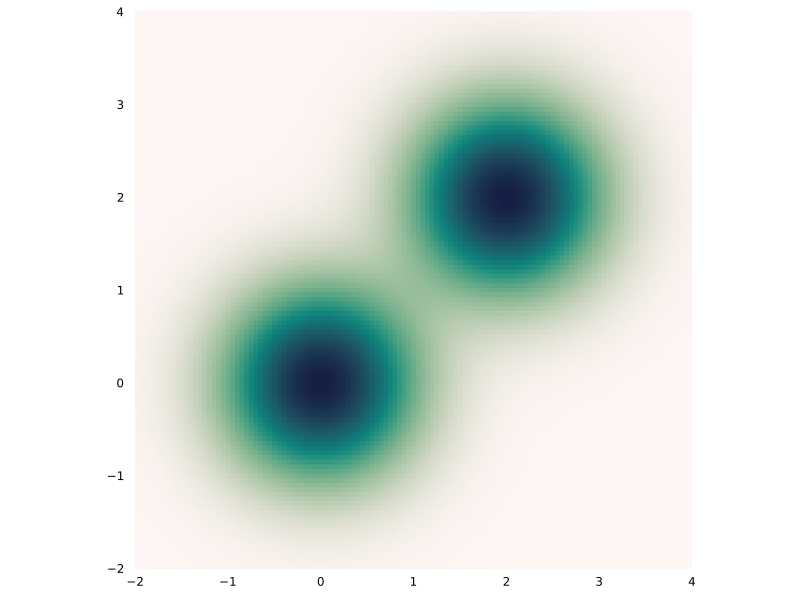

In [35]:
z = rbf.(x, weights=w,centers=mu,sigma2=sigma2)
heatmap(x1,x2,z, aspect_ratio=:equal, c=:tempo, axis=:off, lims=(min(x1[1],x2[1]),max(x1[end],x2[end])),colorbar=:none)

In [5]:
# using GeometryBasics
function sample_rbf(N,rbf_func,xlims,ylims,cota=2.0)
    
    v=Vector{Point2}(undef,N)
    n=0
    
    while(n<N)
        
        u1 = rand(Uniform(xlims[1],xlims[2]))
        u2 = rand(Uniform(ylims[1],ylims[2]))

        u = rand(Uniform())
        
        val  = rbf_func([u1,u2])
        
        if val/cota > u
            #accept
            n=n+1
            v[n] = Point2(u1,u2)
        end
    end
    return v
end

sample_rbf (generic function with 2 methods)

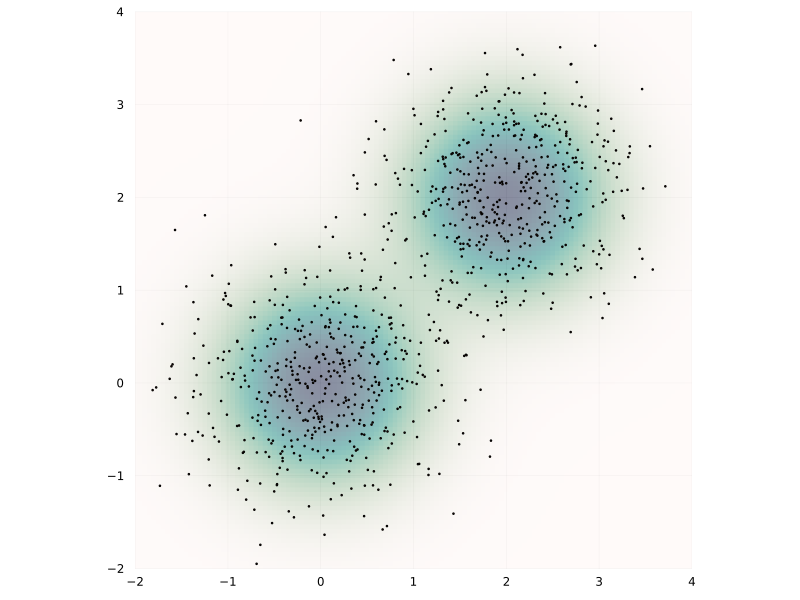

In [6]:
# sample_rbf(N = Sample counts, rbf_func = ,xlims,ylims,cota=2.0)
points = sample_rbf(1000,x->rbf(x,weights=w,centers=mu,sigma2=sigma2),(x1[1],x1[end]), (x2[1],x2[end]))

heatmap(x1,x2,z, aspect_ratio=:equal, c=:tempo, axis=:off, lims=(min(x1[1],x2[1]),max(x1[end],x2[end])),colorbar=:none, alpha=0.5)
scatter!(points, aspect_ratio=:equal, axis=:off, lims=(min(x1[1],x2[1]),max(x1[end],x2[end])), label=:none, ms=1)

In [7]:
function integrate2(h,grid,dx,dy)
    return sum(h.(grid)*dx*dy)
end

integrate2(x->rbf(x,weights=w,centers=mu,sigma2=sigma2),x,.05,.05)

0.995826076410277

In [8]:
X1 = [u.data[1] for u in points];
X2 = [u.data[2] for u in points];

#mean(map(x->(x-mu),points)) # No hace bien la "traslación" (x-mu), hay más de 1 vectore de centros

## Example
Genarate $n$ "sites" $(x_1, ..., x_n)$ in $\mathbb{R}^2$ with "mass" $y_i$ for each one.

In [9]:
# METAPARAMETERS

import Random
Random.seed!(100)

X1_min = -1;
X1_max = 1;
Delta_X1 = X1_max - X1_min
X2_min = -1;
X2_max = 1;
Delta_X2 = X2_max - X2_min
P = 3000; #Cantidad de puntos a sortear

s = 10 # Count of sites 
d = 2 # Space Dimension

x = sortslices(rand(Uniform(0,1),s,d), dims = 1) # Sites coordinates in R^d
x1 = x[:,1] = x[:,1].*Delta_X1.+X1_min
x2 = x[:,2] = x[:,2].*Delta_X2.+X2_min

X = sortslices(rand(Uniform(0,1),P,d), dims = 1); # Auxiliar points to integrate
X1 = X[:,1] = X[:,1].*Delta_X1.+X1_min
X2 = X[:,2] = X[:,2].*Delta_X2.+X2_min

y = rand(s); # Sites demands
n = 3; # Count of kernels
A_X = Delta_X1*Delta_X2;
w = [1/(2*pi) for j=1:n]; #Pesos iniciales (TODO: paso C inicialización)

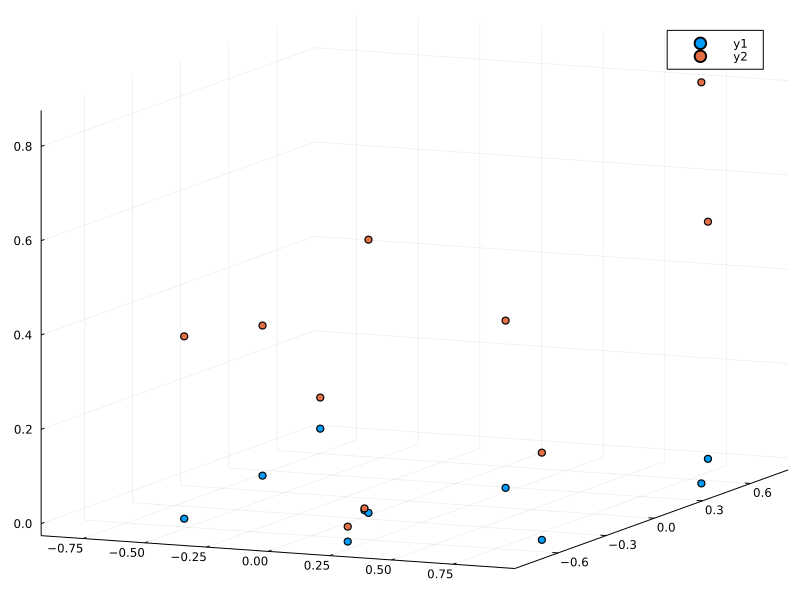

In [10]:
scatter(x1,x2,[0 for i in 1:s])
#TODO: Agregar "demandas" con radios
scatter!(x1,x2,y)

## Initialization

1. Find  𝑛  centroids for the sites  𝑥𝑖 . These will be the starting  𝜇𝑗 .

In [11]:
# K - means with Sites coordinates
R = kmeans(x', n, weights = y, maxiter = 200, display=:iter);

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.084299e+00
      1       7.014758e-01      -1.382823e+00 |        2
      2       4.633267e-01      -2.381491e-01 |        2
      3       4.178548e-01      -4.547192e-02 |        0
      4       4.178548e-01       0.000000e+00 |        0
K-means converged with 4 iterations (objv = 0.4178548051817338)


In [12]:
#nclusters(R)
#assignments(R)
#counts(R)
mu = [[R.centers'[i,1],R.centers'[i,2]] for i=1:n]
mu1 = R.centers'[:,1]
mu2 = R.centers'[:,2]

3-element Vector{Float64}:
 -0.2411661317880984
 -0.27782769948029884
  0.5116607081809005

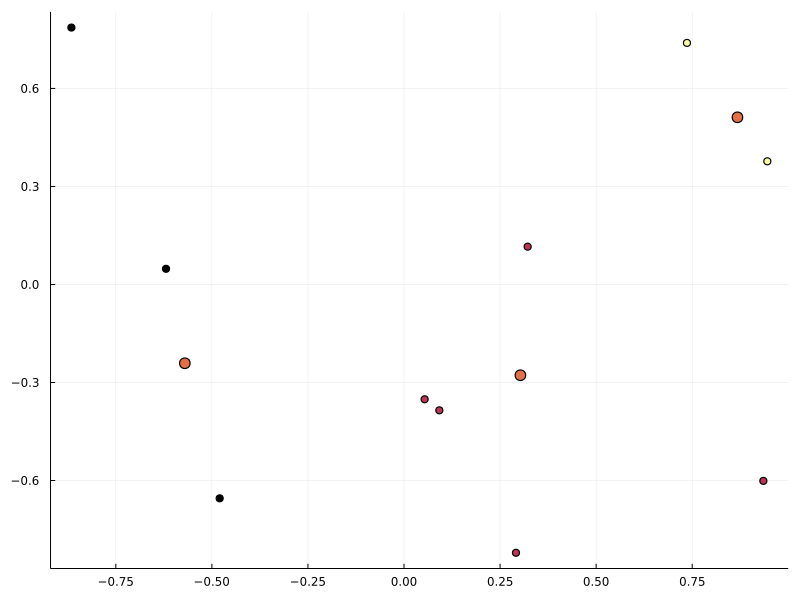

In [13]:
scatter(x1, x2, marker_z = R.assignments, color =:blue, legend = false)
scatter!(mu1,mu2, markersize = 6)

2. Compute the covariance matrix of each cluster. Use  $\sigma^2_j$  as the trace of the covariance matrix (dispersion measure of the cluster).

In [14]:
sigma2 = [var(x[findall(x->x==i,assignments(R)),:]) for i in 1:n]
#sigma2 = sum(sigma2_vector) #Traza de la matriz de covarianza

3-element Vector{Float64}:
 0.37622869846972323
 0.2648247847251015
 0.05582509807754669

3. 3. Solve the finite-dimensional least squares problem to find the remaining initial weights, sampling from the RBF kernels (with weight 1) to solve the integrals.

## Visualization

In [15]:
# Calculate all distances between auxiliar points and sites
norm = 2
W = [(sum((x[i,:]-X[k,:]).^norm))^(1/norm) for i=1:s,k=1:P]; # Norm 2 (ponderada por y)

attachs = zeros(P)
for k=1:P    
    _,idx = findmin(W[:,k])
    attachs[k] = idx
end
attachs=Int64.(attachs);

In [16]:
X1_rbf=(X1_min:.005:X1_max)
X2_rbf=(X2_min:.005:X2_max)
X_rbf = [[a,b] for b in X2_rbf, a in X1_rbf]
z = rbf.(X_rbf, weights=w, centers=mu, sigma2=sigma2);

In [17]:
rect = Rectangle(Point2(X1_min, X2_min), Point2(X1_max, X2_max));

x_aux = Point2{Float64}[]
for i=1:s
    aux = Point2(x1[i],x2[i])
    push!(x_aux,aux)
end
tess = voronoicells(x_aux, rect);

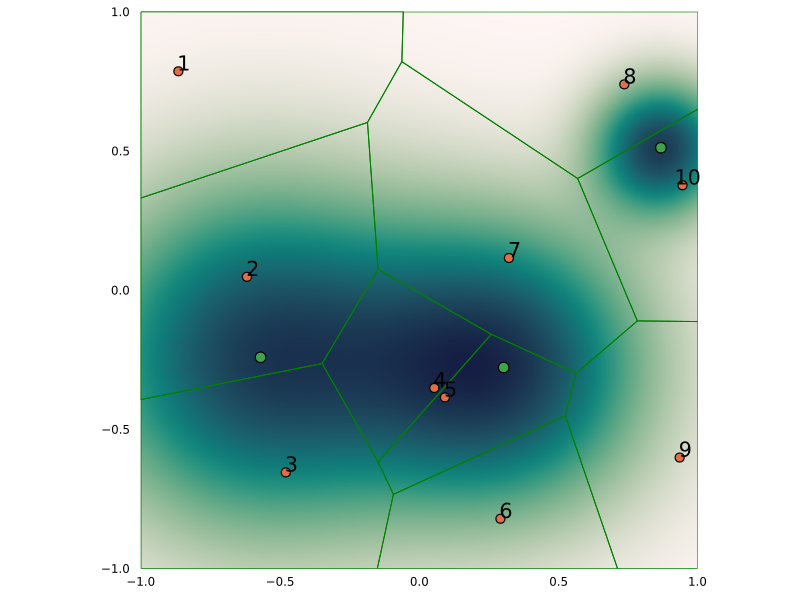

In [33]:
heatmap(X1_rbf,X2_rbf,z, aspect_ratio=:equal, c=:tempo, axis=:off, lims=(min(X1_min,X2_min),max(X1_max,X2_max)),colorbar=:none)
scatter!(x1, x2, legend=:none, colorbar=:none, markersize = 5)

annotate!([(x1[i] + 0.02, x2[i] + 0.03, text(i, :black)) for i in 1:s]) # Add Station Number

#for k=1:P
#    if attachs[k] == 9 
#        plot!([X1[k],x1[attachs[k]]], [X2[k],x2[attachs[k]]], color=:gray, alpha=0.3)
#    end
#end

#scatter!(X1,X2, marker_z = attachs, xlims=(X1_min,X1_max), ylims=(X2_min,X2_max), marker=:square, markersize = 3)
scatter!(mu1,mu2, markersize = 6)

plot!(tess, alpha=1, color=:green)

# Integrate

Algorithm to integrate a function in the Voronoi Cells defined by its centers in 1 by 1 square

In [19]:
sigma2

3-element Vector{Float64}:
 0.37622869846972323
 0.2648247847251015
 0.05582509807754669

In [20]:
function integrate_voronoi(g, h, A_X, P)
    return A_X/P*sum(g.*h)
end

function g(x;w,mu,sigma2)
   return rbf(x, weights=w, centers=mu, sigma2=sigma2)
end

function h(x;w,mu,sigma2)
    return 1
end

function g_j(x;j,w,mu,sigma2)
   return rbf(x, weights=[w[j]], centers=[mu[j]], sigma2=[sigma2[j]])
end

function h0_j(x;j,w,mu,sigma2)
    return 1/w[j]
end

function h1_j(x;j,w,mu,sigma2)
    return (x-mu[j])'*(x-mu[j])/(sigma2[j]^4)
end

function h2_j(x;j,w,mu,sigma2)
    return  -2/sigma2[j]^2*(x-mu[j])
end

h2_j (generic function with 1 method)

In [21]:
#Armar los conjuntos x (celdas de voronoi)
v_i = [ X[findall(x->x==i,attachs),:] for i in 1:s ];

#scatter(v_i[9][:,1], v_i[9][:,2], lims=(min(X1_min,X2_min),max(X1_max,X2_max)))

In [22]:
integrates = zeros(s)
for i=1:s
    v = [[v_i[i][l,1], v_i[i][l,2]] for l=1:size(v_i[i])[1]];
    
    # For each station -> Integrates the RBF 
    g_out = g.(v, w=w, mu=mu, sigma2=sigma2)
    h_out = h.(v, w=w, mu=mu, sigma2=sigma2)
    integrates[i] = integrate_voronoi(g_out, h_out, A_X, P)
end

error_i = integrates - y

10-element Vector{Float64}:
 -0.05912230770782187
 -0.25828655538920225
 -0.33428595438590836
  0.02561591618234713
 -0.548944581711276
 -0.00823680461254784
 -0.3028552506946063
 -0.4920840286596637
 -0.16982183019739608
 -0.836628954303601

In [23]:
n0_ij = zeros(s,n)
n1_ij = zeros(s,n)
n2x1_ij = zeros(s,n)
n2x2_ij = zeros(s,n)

for i=1:s
    v = [[v_i[i][l,1], v_i[i][l,2]] for l=1:size(v_i[i])[1]];
    for j=1:n
        # Evaluaciones
        g_j_out  = g_j.(v, j=j, w=w, mu=mu, sigma2=sigma2)
        h0_j_out = h0_j.(v, j=j, w=w, mu=mu, sigma2=sigma2)
        h1_j_out = h1_j.(v, j=j, w=w, mu=mu, sigma2=sigma2)
        h2_j_out = h2_j.(v, j=j, w=w, mu=mu, sigma2=sigma2)
        
        # Integrales
        n0_ij[i,j] = (integrate_voronoi(g_j_out, h0_j_out, A_X, P))
        n1_ij[i,j] = (integrate_voronoi(g_j_out, h1_j_out, A_X, P))
        n2x1_ij[i,j] = (integrate_voronoi(g_j_out, [h2_j_out[l][1] for l = 1:length(h2_j_out)], A_X, P))
        n2x2_ij[i,j] = (integrate_voronoi(g_j_out, [h2_j_out[l][2] for l = 1:length(h2_j_out)], A_X, P))
    end
end

In [24]:
dL_w_j = zeros(n)
dL_sigma2_j = zeros(n)
dL_mux1_j = zeros(n)
dL_mux2_j = zeros(n)

for j = 1:n
    dL_w_j[j] = sum(error_i.*n0_ij[:,j])
    dL_sigma2_j[j] = sum(error_i.*n1_ij[:,j])
    dL_mux1_j[j] = sum(error_i.*n2x1_ij[:,j])
    dL_mux2_j[j] = sum(error_i.*n2x2_ij[:,j])
end

dL_mu_j = [[dL_mux1_j[i], dL_mux2_j[i]] for i = 1:3]

3-element Vector{Vector{Float64}}:
 [0.18601164026188774, -0.027226310440948042]
 [0.04435320274047509, 0.30038935269284167]
 [-1.4096956795116966, -0.37430733698710705]

In [25]:
println("dL_w_j: ", dL_w_j)
println("dL_sigma2_j: ", dL_sigma2_j)
println("dL_mux1_j: ", dL_mux1_j)
println("dL_mux2_j: ", dL_mux2_j)
println("dL_mu_j: ", dL_mu_j)

dL_w_j: [-0.7055795510143299, -0.6565424176599503, -0.23765222430290373]
dL_sigma2_j: [-1.6110829909662925, -4.724539801531766, -174.71168710111124]
dL_mux1_j: [0.18601164026188774, 0.04435320274047509, -1.4096956795116966]
dL_mux2_j: [-0.027226310440948042, 0.30038935269284167, -0.37430733698710705]
dL_mu_j: [[0.18601164026188774, -0.027226310440948042], [0.04435320274047509, 0.30038935269284167], [-1.4096956795116966, -0.37430733698710705]]


## Gradient Step

In [26]:
nu = 0.05;

In [27]:
w = w - nu*dL_w_j

3-element Vector{Float64}:
 0.19443392064261183
 0.19198206397489287
 0.17103755430704054

In [28]:
sigma2 = sigma2 - nu*dL_sigma2_j

3-element Vector{Float64}:
 0.45678284801803787
 0.5010517748016898
 8.79140945313311

In [29]:
mu = mu  - nu*dL_mu_j

3-element Vector{Vector{Float64}}:
 [-0.5797320875389931, -0.239804816266051]
 [0.30069550541350415, -0.2928471671149409]
 [0.9382993906548489, 0.5303760750302559]

In [30]:
theta = w, sigma2, mu

([0.19443392064261183, 0.19198206397489287, 0.17103755430704054], [0.45678284801803787, 0.5010517748016898, 8.79140945313311], [[-0.5797320875389931, -0.239804816266051], [0.30069550541350415, -0.2928471671149409], [0.9382993906548489, 0.5303760750302559]])

In [31]:
theta[1]

3-element Vector{Float64}:
 0.19443392064261183
 0.19198206397489287
 0.17103755430704054